# Convolutuinal Neural Networks With Dataset
Now it's time to talk about convolutional neural networks and in this notebook you will find out how to the dataset library to do:
* data augmentation
* early stopping
* learning rate decay.

In this example the [batch class](./../utils/secondbatch.py) and the [model](./../utils/simple_conv_model.py) are used.

In [1]:
import sys

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('../..')
sys.path.append('../utils')

import utils
from secondbatch import MnistBatch
from simple_conv_model import ConvModel

from dataset import B, V, F, R, P
from dataset.opensets import MNIST

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

Instead of generating data, you can implement a basic batch class with preloaded [MNIST](https://analysiscenter.github.io/dataset/api/dataset.opensets.html#mnist) dataset.

In [2]:
mnist = MNIST(batch_class=MnistBatch)

ExtractingExtractingExtracting   /tmp/t10k-images-idx3-ubyte.gz/tmp/train-images-idx3-ubyte.gz/tmp/train-labels-idx1-ubyte.gzExtracting


 /tmp/t10k-labels-idx1-ubyte.gz


As we already learned from the previous tutorials, first of all you have to define config and create train and test pipelines. 

Let's create a config for a model. If you open the file with the [model](./../utils/simple_conv_model.py) you can see [__default_config__](https://analysiscenter.github.io/dataset/api/dataset.models.tf.base.html#dataset.models.tf.base.TFModel.default_config). It is a function, that allows to add the default configuration to the model.

But if you want to override default config you can add parameters in model config. For example:

ConvModel has dict __config__ with key __'body'__. You can override it by adding in __model_config__ key __'body'__ with dict of parameters of body function.

Models are split in three parts:
* __input_block__ - block containing the input layers.
* __body__ - the main part of the model
* __head__ - outputs layers, like global average pooling or dense layers.

Or add useful params by typing in a __model_config__ key like __'body/layout'__ and params to this key. Similar way use it in the key __'input_block/inputs'__ or __'head/units'__. In [docs](https://analysiscenter.github.io/dataset/intro/tf_models.html#model-structure) you can read more.

In [3]:
model_config = {
    'inputs': dict(images={'shape': (28, 28, 1)},
                   labels={'classes': (10), 
                           'transform': 'ohe', 
                           'name': 'targets'}),
    'loss': 'ce',
    'decay': ('exp', {'learning_rate': 0.001,
                      'decay_steps': 150,
                      'decay_rate': 0.96}),
    'optimizer': 'RMSProp',
    'input_block/inputs': 'images',
    'head/units': 10,
    'output': dict(ops=['labels', 'proba', 'accuracy'])
}

And don't forget about feed dict

In [4]:
data_dict = {
    'images': B('images'),
    'labels': B('labels')
}

When config is defined, next step is to create a pipeline. Note that __random_rotate__ and __random_scale__ are methods of the __ImagesBatch__ class(parent of our class). You can see all avalible augmentations in [images tutorial](07_image_augmentation_examples.ipynb).

In contrast to them __shift_flattned_pic__ is a function from [batch class](./../utils/secondbatch.py). It is worth mentioning because it runs in parallel. About parallel method read [docs](https://analysiscenter.github.io/dataset/intro/parallel.html).

In [5]:
def factor_sampler(size, p_square = 0.5):
    if np.random.binomial(1, p_square):
        return np.random.uniform(0.5, 1.5, (size,))
    return np.random.uniform(0.5, 1.5, (size,2))
train_pipeline = (
    mnist.train.p
    .shift_flattened_pic()
    .rotate(angle=P(R('uniform',-10, 10)), p=0.8)
    .crop(shape=(28, 28), origin='center')
    .scale(factor=P(R(factor_sampler)), preserve_shape=True, p=0.8) 
    .multiply(multiplier=1/255., preserve_type=False)
    .init_variable('train_accuracy', init_on_each_run=list)
    .init_model('dynamic',
                ConvModel,
                'conv',
                config=model_config)
     .train_model('conv',
                  fetches='output_accuracy',
                  feed_dict=data_dict,
                  save_to=V('train_accuracy'), mode='a')
)

And test on the augmented data

In [6]:
test_pipeline = (
    mnist.test.p
    .import_model('conv', train_pipeline)
    .shift_flattened_pic()
    .rotate(angle=P(R('uniform',-10, 10)), p=0.8)
    .crop(shape=(28, 28), origin='center')
    .scale(factor=P(R(factor_sampler)), preserve_shape=True, p=0.8) 
    .multiply(multiplier=1/255., preserve_type=False)
    .init_variable('test_accuracy', init_on_each_run=list)
    .predict_model('conv', 
             fetches='output_accuracy',
             feed_dict=data_dict,
             save_to=V('test_accuracy'), mode='a')
)

We introduce early stopping to terminate the model when average accuracy in 'window' epochs will be more than 0.95 percent

In [7]:
MAX_ITER = 700
window = 50
average = [0]
batch_size = 100

for curr_iter in tqn(range(1, MAX_ITER + 1)):

    train_pipeline.next_batch(batch_size, n_epochs=None)
    test_pipeline.next_batch(batch_size, n_epochs=None)

    if curr_iter % window == 0:
        average.append(np.mean(test_pipeline.get_variable('test_accuracy')[curr_iter - window:]))

    #Early stopping   
    if average[-1] > 0.95:
        print('Early stop on {} iter. Acc: {}'.format(curr_iter, stats[-1]))
        break

Now we predict image class on test data and draw accuracy graph

../../utils.py:44: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../../utils.py:45: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


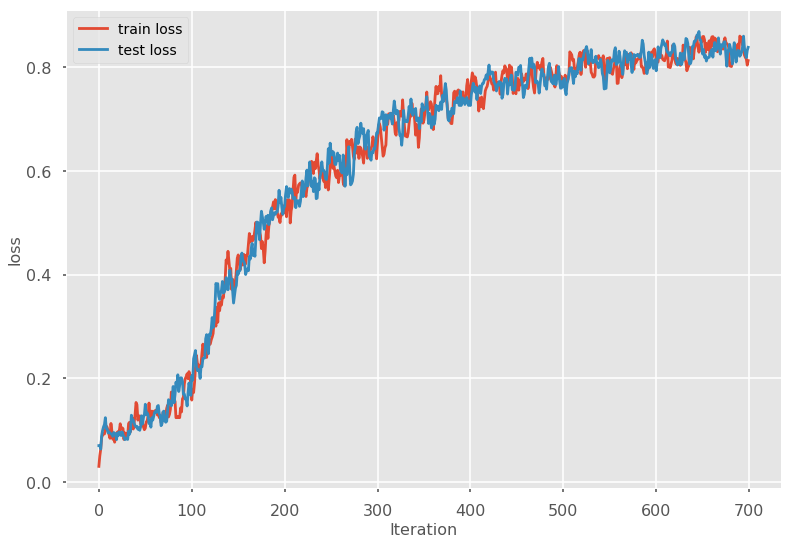

In [8]:
train_accuracy = train_pipeline.get_variable('train_accuracy')
test_accuracy = test_pipeline.get_variable('test_accuracy')
utils.draw(train_accuracy,'train', test_accuracy, 'test', 'loss')

Accuracy graph is probably good, but what about real predictions?

In [9]:
validation_pipeline = (mnist.test.p
                       .import_model('conv', train_pipeline)
                       .shift_flattened_pic()
                       .rotate(angle=P(R('uniform',-10, 10)), p=0.8)
                       .crop(shape=(28, 28), origin='center')
                       .scale(factor=P(R(factor_sampler)), preserve_shape=True, p=0.8) 
                       .multiply(multiplier=1/255., preserve_type=False)
                       .init_variable('answers', init_on_each_run=list)
                       .init_variable('img', init_on_each_run=list)
                       .init_variable('predict', init_on_each_run=list)
                       .init_variable('prob', init_on_each_run=list)
                       .predict_model('conv', 
                                      fetches=['labels', 
                                               'images', 
                                               'output_labels', 
                                               'output_proba'],
                                      feed_dict=data_dict,
                                      save_to=[V('answers'),
                                               V('img'), 
                                               V('predict'), 
                                               V('prob')],
                                      mode='a'))

It's always interesting to look at the images, so let's draw them.

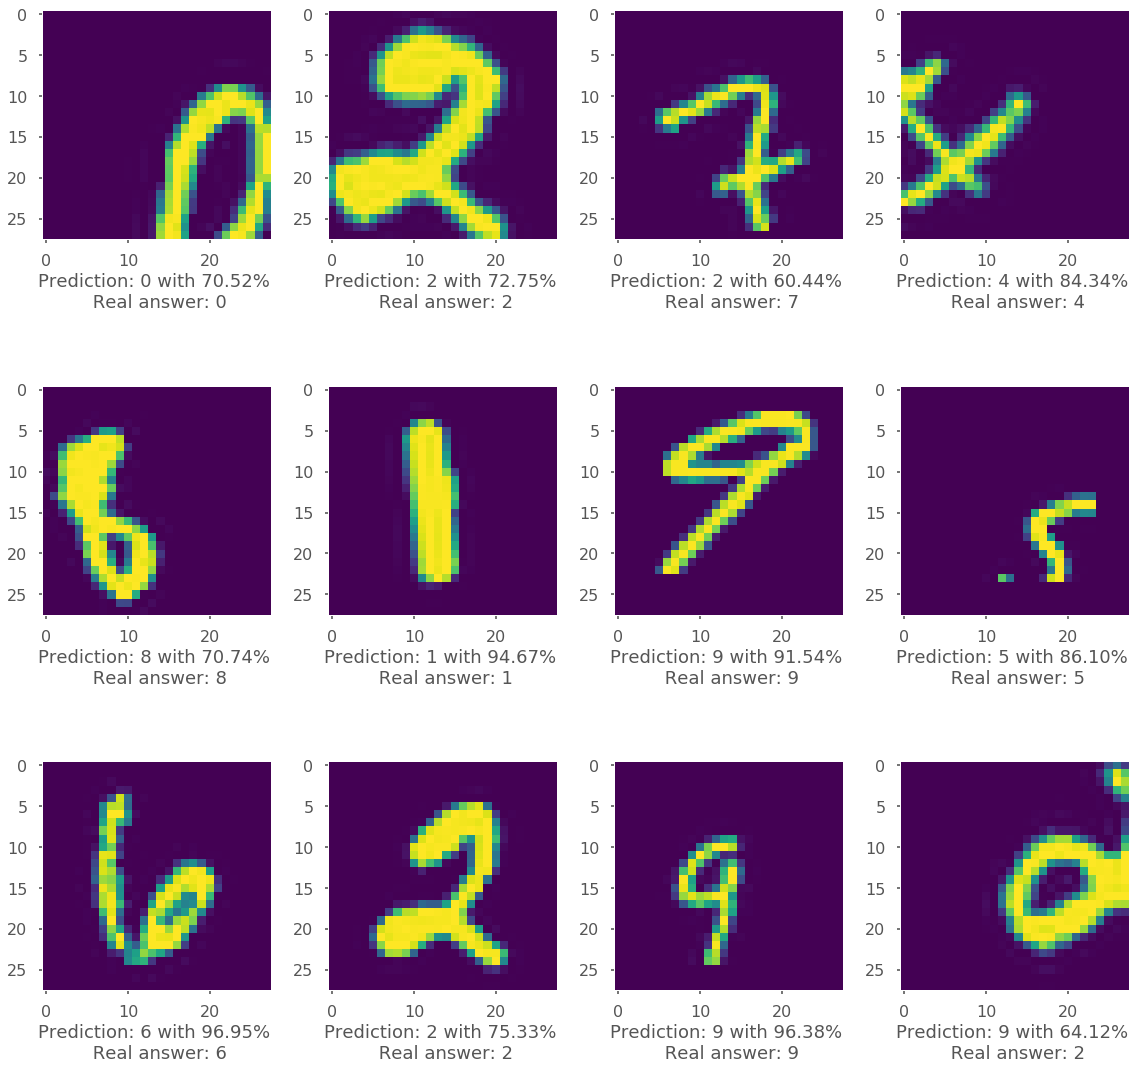

In [10]:
_, ax = plt.subplots(3, 4, figsize=(16, 16))
ax = ax.reshape(-1)


for num_batch in range(12):
    validation_pipeline.next_batch(1, n_epochs=None, shuffle=True)
    answer= validation_pipeline.get_variable('answers')
    img = validation_pipeline.get_variable('img')
    predict = validation_pipeline.get_variable('predict')
    prob = validation_pipeline.get_variable('prob')
    ax[num_batch].imshow(img[-1].reshape(-1, 28))
    ax[num_batch].set_xlabel('Prediction: {} with {:.2f}% \n Real answer: {}'\
                             .format(predict[-1][0],
                             prob[-1][0] \
                             [np.argmax(prob[-1])]*100, \
                             answer[-1][0]),\
                             fontsize=18)
    ax[num_batch].grid()
plt.tight_layout(pad=0.4, w_pad=0., h_pad=1.0)
plt.show()

# Conclusion
Today you learned how to:
* create convolutional neural network with the Dataset.
* easily load MNIST data without writing your own loading functions.
* perforn data augmentation with dataset.
* configure the model using model config.

And found out that network can be more robust with data augmentations (like scale and rotate). 

### And what's next?
Because you know how to configure convolution model, you can create:
* model with MNIST 3-channels data, instead 1 in our example.
* config to our model, with own parameters of the network. Your goal is 0.95 on the test data!
Good luck!

See [the next tutorial](./05_basic_model_usage.ipynb) if you want to know more or return to the [table of contents](./00_description.ipynb).

Previous [tutorial](./03_pipeline_operations.ipynb).